# Twitter Disaster Tweet Classifier with DistilBERT

## Visualize the Dataset

### Load Imports

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

### Load and Format

In [29]:
# Read from CSV
dataset = pd.read_csv("train.csv")

# Drop (potentially) unnecessary columns. These may be useful, but I'm not quite ready to work with missing data.
dataset = dataset.drop(["id", "keyword", "location"], axis=1)
dataset.head(20)

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
5,#RockyFire Update => California Hwy. 20 closed...,1
6,#flood #disaster Heavy rain causes flash flood...,1
7,I'm on top of the hill and I can see a fire in...,1
8,There's an emergency evacuation happening now ...,1
9,I'm afraid that the tornado is coming to our a...,1


### Visualize

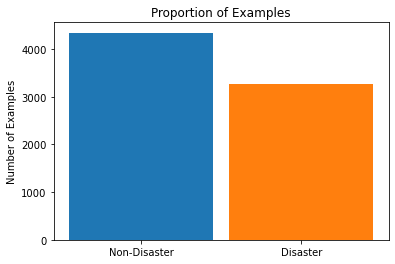

In [30]:
# Get the count of each label. Posative indicates that the tweet is about a disaster.
posative_count = dataset[dataset["target"] == 1].shape[0]
negative_count = dataset[dataset["target"] == 0].shape[0]

plt.bar("Non-Disaster",negative_count,0.9, label="Non-Disaster")
plt.bar("Disaster",posative_count,0.9, label="Disaster")
plt.ylabel('Number of Examples')
plt.title('Proportion of Examples')
plt.show()

## Fine-Tune Pretrained Model for Inference 

Below, I use the HuggingFace `transformers` library to fine-tune DistilBERT on the tweets dataset. 

### Load Imports

In [31]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import AutoTokenizer, DataCollatorWithPadding
from datasets import load_dataset
import torch

### Create Dataset

In [32]:
# Init tokenizer for converting text to numbers
model_path = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_path)

# In order to add padding on a batch-level rather than a dataset level, add dynamic padding using a data 
# collator. This will add padding to the maximum input in a batch rather than the entire 
# data set which saves computation. 
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Read data from CSV, embed, and split into test and train
raw_dataset = load_dataset("csv", data_files="train.csv")
raw_dataset = raw_dataset.remove_columns(["keyword", "location", "id"])
raw_dataset = raw_dataset.rename_column("target", "labels")
raw_dataset = raw_dataset.map(lambda example: tokenizer(example["text"]), batched=True)
raw_dataset = raw_dataset.with_format("torch")
formatted_datasets = raw_dataset["train"].train_test_split(0.2)

# Show Output
formatted_datasets

loading configuration file https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english/resolve/main/config.json from cache at /home/kdobrien/.cache/huggingface/transformers/4e60bb8efad3d4b7dc9969bf204947c185166a0a3cf37ddb6f481a876a3777b5.9f8326d0b7697c7fd57366cdde57032f46bc10e37ae81cb7eb564d66d23ec96b
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased-finetuned-sst-2-english",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "finetuning_task": "sst-2",
  "hidden_dim": 3072,
  "id2label": {
    "0": "NEGATIVE",
    "1": "POSITIVE"
  },
  "initializer_range": 0.02,
  "label2id": {
    "NEGATIVE": 0,
    "POSITIVE": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "ti

  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/kdobrien/.cache/huggingface/datasets/csv/default-2de43190c5bb368c/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-1c80317fa3b1799d.arrow
Loading cached split indices for dataset at /home/kdobrien/.cache/huggingface/datasets/csv/default-2de43190c5bb368c/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-56d660b3f4fc7ddf.arrow and /home/kdobrien/.cache/huggingface/datasets/csv/default-2de43190c5bb368c/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-ae4df26c8542b7f3.arrow


DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 6090
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 1523
    })
})

### Configure Trainer

In [33]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)
model.to(device)

print(f"Running on Device Type: {device.type}")

training_arguments = TrainingArguments("test-trainer")
trainer = Trainer(
    model,
    training_arguments,
    train_dataset=formatted_datasets["train"],
    eval_dataset=formatted_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)


loading configuration file https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english/resolve/main/config.json from cache at /home/kdobrien/.cache/huggingface/transformers/4e60bb8efad3d4b7dc9969bf204947c185166a0a3cf37ddb6f481a876a3777b5.9f8326d0b7697c7fd57366cdde57032f46bc10e37ae81cb7eb564d66d23ec96b
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased-finetuned-sst-2-english",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "finetuning_task": "sst-2",
  "hidden_dim": 3072,
  "id2label": {
    "0": "NEGATIVE",
    "1": "POSITIVE"
  },
  "initializer_range": 0.02,
  "label2id": {
    "NEGATIVE": 0,
    "POSITIVE": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "ti

Running on Device Type: cpu


### Execute the Training/Fine-Tuning Run

In [35]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 6090
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2286


Step,Training Loss


KeyboardInterrupt: 